In [22]:
from keras.models import load_model, model_from_json
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, GlobalAveragePooling2D, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import matplotlib.patches as patches
%matplotlib inline

In [2]:
classifier = load_model('VGG16-finetuned_last3-27-0.70.hdf5')

In [3]:
classifier.save_weights('test.hdf5')

In [4]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [2]:
img_input = Input(shape=(224, 224, 3), name='input_3')
# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
feat_map1 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
fmap1_mean = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True), name='mean_1')(feat_map1)
feat_map2 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
fmap2_mean = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True), name='mean_2')(feat_map2)
feat_map3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
fmap3_mean = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True), name='mean_3')(feat_map3)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(feat_map3)

# Classifier
x = GlobalAveragePooling2D(name='global_average_pooling2d_2')(x)
x = Dense(256, activation='relu', name='dense_3')(x)

x = Dropout(0.5, name='dropout_2')(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(20, activation='softmax', name='dense_4')(x)

concat = Lambda(lambda x : K.concatenate([x[0], x[1], x[2]], axis=-1), name='concat')([fmap1_mean, fmap2_mean, fmap3_mean])

x  = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='bbox_conv1')(concat)
x = BatchNormalization(name='bbox_bn_1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='bbox_conv2')(x)
x = BatchNormalization(name='bbox_bn_2')(x)
x = Flatten(name='bbox_flatten')(x)
bbox = Dense(4, name='bbox')(x)

test = Model(inputs=img_input, outputs=bbox)

In [3]:
test.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [4]:
test.load_weights('test.hdf5', by_name=True)

In [5]:
for num, layer in enumerate(test.layers):
    print(num, layer.name)

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 mean_1
19 mean_2
20 mean_3
21 concat
22 bbox_conv1
23 bbox_bn_1
24 bbox_conv2
25 bbox_bn_2
26 bbox_flatten
27 bbox


In [6]:
for layer in test.layers[:18]:
    layer.trainable = False
for layer in test.layers[18:]:
    layer.trainable = True

In [7]:
test.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [10]:
test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
from skimage.io import imread
from skimage.transform import resize

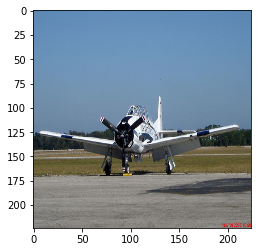

In [9]:
test_im = imread('bbox_dataset/images/2008_000021.jpg')
test_im = resize(test_im, (224, 224), mode='reflect')
plt.imshow(test_im)

In [10]:
import numpy as np

In [15]:
test_im = np.expand_dims(test_im, 0)
test_im.shape

(1, 224, 224, 3)

In [12]:
preds = test.predict(test_im)

In [13]:
preds.shape

(1, 4)

In [24]:
labels = np.zeros(preds[0].shape)
labels[preds[0]>0.5] = 1
np.argmax(labels, axis=-1)

array([0], dtype=int64)

In [23]:
preds[1].shape

(1, 4)

In [11]:
import os
import numpy as np
import xml.etree.ElementTree as etree
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
img_path = './bbox_dataset/images/'
annot_path = './bbox_dataset/annotations/'

In [13]:
import pickle

In [14]:
with open('final_parition.pkl', 'rb') as part_file:
    final_parition = pickle.load(part_file)

with open('labels_bbox_only.pkl', 'rb') as bboxes_only:
    labels_bbox_only = pickle.load(bboxes_only)

In [15]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize

class DataGenerator(object):

    def __init__(self, dim_x = 224, dim_y = 224, channels = 3, batch_size = 32, shuffle = True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = channels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def generate(self, labels, list_IDs):
        'Generates batches of samples'
        # Infinite loop
        while 1:
        # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(list_IDs)

            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
            # Find list of IDs
                list_IDs_temp = [list_IDs[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

                # Generate data
                X, y = self.__data_generation(labels, list_IDs_temp)

                yield X, y

    def __get_exploration_order(self, list_IDs):
        'Generates order of exploration'
        # Find exploration order
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)
        return indexes

    def __data_generation(self, labels, list_IDs_temp):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        y = np.empty((self.batch_size, 4), dtype = int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            img = imread('./bbox_dataset/images/'+ID+'.jpg')
            real_h, real_w, c = img.shape
            img = resize(img, (self.dim_x, self.dim_y), mode='reflect')
            
            X[i] = img

            # Store volume
            #X[i, :, :, :, 0] = np.load(ID + '.npy')

            # Fixing the bbox after image resize
            bbox = labels[ID]
            
            xmin = int(bbox[0] * self.dim_x / real_w)
            xmin = max(min(xmin, real_w), 0)
            xmax = int(bbox[2] * self.dim_x / real_w)
            xmax = max(min(xmax, real_w), 0)
            ymin = int(bbox[1] * self.dim_y / real_h)
            ymin = max(min(ymin, real_h), 0)
            ymax = int(bbox[3] * self.dim_y / real_h)
            ymax = max(min(ymax, real_h), 0)
            
            y[i] = (xmin, ymin, xmax, ymax)
            

        return X, y


In [16]:
params = {'dim_x': 224,
          'dim_y': 224,
          'channels': 3,
          'batch_size': 16,
          'shuffle': False}

# Datasets
partition = final_parition # IDs
labels = labels_bbox_only # Labels

# Generators
training_generator = DataGenerator(**params).generate(labels, partition['train'])
validation_generator = DataGenerator(**params).generate(labels, partition['valid'])

In [17]:
test.compile(optimizer=SGD(lr=0.0001, momentum=0.9),loss='mean_squared_error',metrics=['accuracy'])

In [18]:
filepath="bboxes_concat-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [19]:
len(final_parition['train']), len(final_parition['valid'])

(3093, 89)

In [20]:
test.fit_generator(training_generator, 3093 // 16, epochs=30 ,validation_data=validation_generator, validation_steps=89//16,
           callbacks=callbacks_list)

Epoch 1/30
193/193 [==============================] - 34s 174ms/step - loss: 2018.1308 - acc: 0.6282 - val_loss: 1608.6550 - val_acc: 0.5750
Epoch 2/30
193/193 [==============================] - 32s 167ms/step - loss: 1049.4296 - acc: 0.6522 - val_loss: 1428.1459 - val_acc: 0.6250
Epoch 3/30
193/193 [==============================] - 32s 166ms/step - loss: 1004.4986 - acc: 0.6548 - val_loss: 1551.8701 - val_acc: 0.6125
Epoch 4/30
193/193 [==============================] - 32s 168ms/step - loss: 981.9608 - acc: 0.6681 - val_loss: 1330.6519 - val_acc: 0.6375
Epoch 5/30
193/193 [==============================] - 32s 168ms/step - loss: 955.5799 - acc: 0.6745 - val_loss: 1237.2487 - val_acc: 0.6125
Epoch 6/30
193/193 [==============================] - 32s 167ms/step - loss: 928.8464 - acc: 0.6823 - val_loss: 1238.8521 - val_acc: 0.6125
Epoch 7/30
193/193 [==============================] - 32s 168ms/step - loss: 903.9871 - acc: 0.6865 - val_loss: 1249.7288 - val_acc: 0.5875
Epoch 8/30
193/19

In [35]:
img_name = final_parition['valid']
img_name

['2011_002505',
 '2011_002533',
 '2011_002566',
 '2011_002623',
 '2011_002706',
 '2011_002770',
 '2011_002935',
 '2011_002969',
 '2011_002997',
 '2011_003141',
 '2011_002673',
 '2011_002751',
 '2011_002929',
 '2011_002930',
 '2011_002992',
 '2011_002993',
 '2011_003034',
 '2011_003111',
 '2011_003154',
 '2011_003275',
 '2011_002636',
 '2011_002738',
 '2011_003059',
 '2011_003124',
 '2011_003146',
 '2011_003149',
 '2011_003187',
 '2011_003197',
 '2011_003228',
 '2011_003274',
 '2011_001572',
 '2011_001597',
 '2011_001607',
 '2011_001716',
 '2011_001754',
 '2011_001775',
 '2011_001841',
 '2011_001971',
 '2011_002004',
 '2011_002034',
 '2011_002128',
 '2011_002211',
 '2011_002276',
 '2011_002389',
 '2011_002409',
 '2011_002461',
 '2011_002631',
 '2011_002664',
 '2011_002685',
 '2011_002699',
 '2011_002724',
 '2011_002883',
 '2011_003211',
 '2011_003216',
 '2011_001727',
 '2011_001745',
 '2011_001855',
 '2011_001868',
 '2011_001984',
 '2011_002040',
 '2011_002121',
 '2011_002279',
 '2011_0

In [51]:
test = load_model('./bboxes-13-0.75.hdf5')

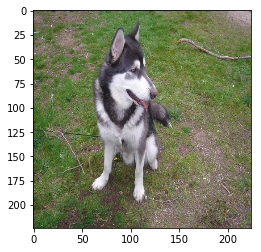

In [52]:
test_img = imread('./bbox_dataset/images/2011_002300.jpg')
test_img = resize(test_img, (224, 224), mode='reflect')
plt.imshow(test_img)

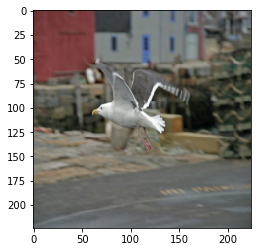

In [35]:
test_img = imread('./bbox_dataset/images/2011_003171.jpg')
test_img = resize(test_img, (224, 224), mode='reflect')
plt.imshow(test_img)

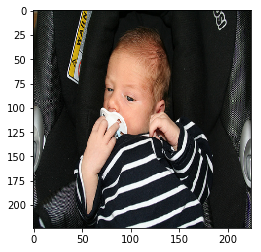

In [39]:
test_img = imread('./bbox_dataset/images/2008_000213.jpg')
test_img = resize(test_img, (224, 224), mode='reflect')
plt.imshow(test_img)

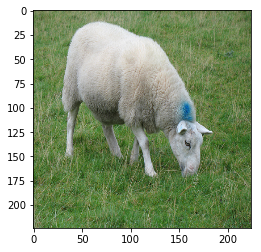

In [31]:
test_img = imread('./test/2011_002817.jpg')
test_img = resize(test_img, (224, 224), mode='reflect')
plt.imshow(test_img)

In [25]:
gt_box = labels['2008_000213']
gt_box

(95, 24, 414, 333)

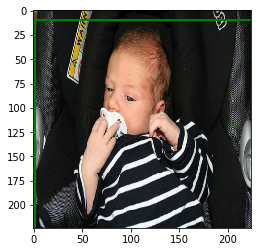

In [55]:
coords = (gt_box[0], gt_box[1]), gt_box[2]-gt_box[0]+1, gt_box[3]-gt_box[1]+1
plt.imshow(test_img)
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

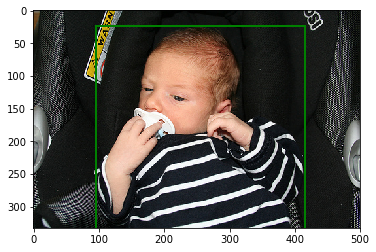

In [26]:
test_img = imread('./bbox_dataset/images/2008_000213.jpg')
coords = (gt_box[0], gt_box[1]), gt_box[2]-gt_box[0]+1, gt_box[3]-gt_box[1]+1
plt.imshow(test_img)
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

In [28]:
test_img.shape

(1, 333, 500, 3)

In [53]:
test_img = np.expand_dims(test_img, 0)
bbox = test.predict(test_img)
bbox

array([[  60.59800339,   30.30807686,  168.31106567,  228.58555603]], dtype=float32)

In [54]:
tbox = np.round(bbox[0])
tbox = bbox.astype(int)
tbox

array([[ 60,  30, 168, 228]])

In [49]:
test_img[0].shape

(224, 224, 3)

#### Performance on the holdout dataset. The holdout dataset consists of classes which didnot have bounding box information and the network was never trained on these bboxes. But still since the base model was trained on these images, the model predicts the object in scene without prior knowledge of the bbox. The holdout classes were horse, sheep, cow and so on

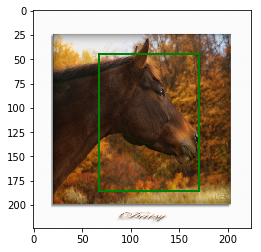

In [77]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

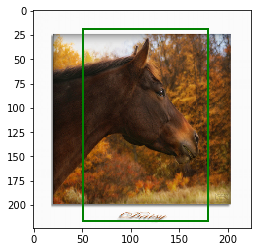

In [25]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

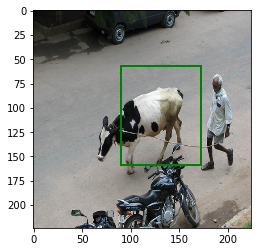

In [73]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

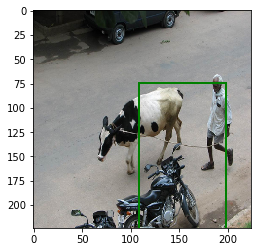

In [29]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

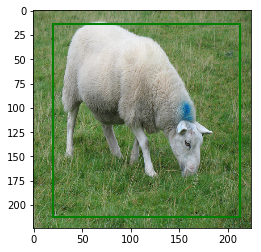

In [68]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

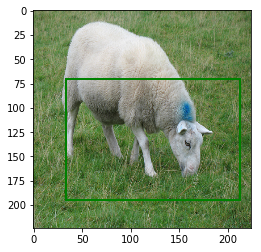

In [34]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

#### General validation check

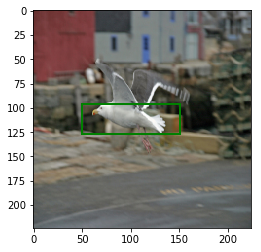

In [64]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

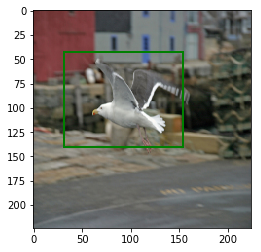

In [38]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

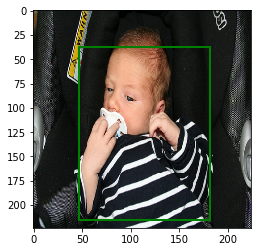

In [56]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

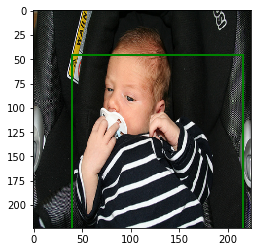

In [42]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

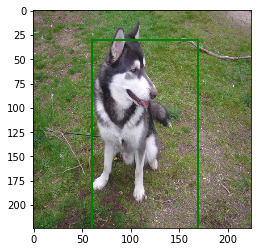

In [55]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

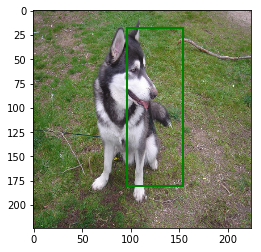

In [50]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

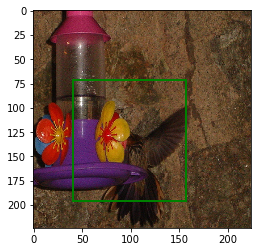

In [46]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

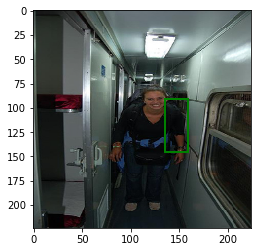

In [39]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

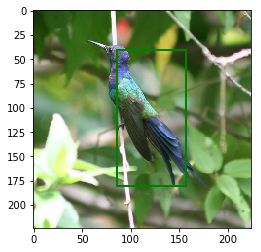

In [43]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

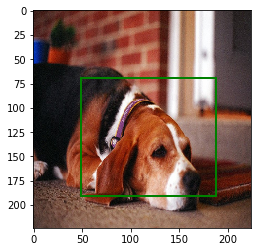

In [47]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

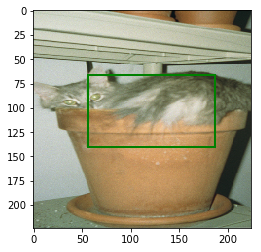

In [60]:
coords = (tbox[0][0], tbox[0][1]), tbox[0][2]-tbox[0][0]+1, tbox[0][3]-tbox[0][1]+1
plt.imshow(test_img[0])
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

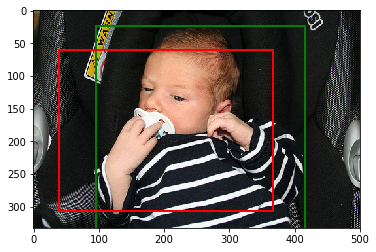

In [61]:
test_img = imread('./bbox_dataset/images/2008_000213.jpg')
xmin, ymin, xmax, ymax = tbox[0][0], tbox[0][1], tbox[0][2], tbox[0][3]
gt_xmin, gt_ymin, gt_xmax, gt_ymax = gt_box[0], gt_box[1], gt_box[2], gt_box[3]
coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
coords_gt = (gt_xmin, gt_ymin), gt_xmax - gt_xmin + 1, gt_ymax - gt_ymin + 1
plt.imshow(test_img)
plt.gca().add_patch(plt.Rectangle(*coords_gt, fill=False, edgecolor='g', linewidth=2))
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='r', linewidth=2))

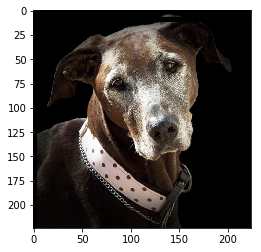

In [28]:
plt.imshow(img)